In [1]:
import numpy as np
import MDAnalysis as mda
import timeit
import matplotlib.pyplot as plt  
import copy
import scipy.special as sp

suw = mda.Universe("swater_prd.tpr","swater_prd.xtc")
uw = mda.Universe("water2_prd.tpr", "water2_prd.xtc")
uh = mda.Universe("hexaice_prd.tpr", "hexaice_prd.xtc")
uc = mda.Universe("cubicice_prd.tpr","cubicice_prd.xtc")

swbox = np.array([23.0, 23.0, 23.0])
wbox = np.array([30.0,   30.0,   30.0])
hbox = np.array([31.5251,   29.6340,   36.4161])
cbox = np.array([32.0350,   32.0350,   32.0350])

In [2]:
def cart2sph(x, y, z):
    r = np.sqrt(x*x+y*y+z*z)
    cos_theta = z/r
    theta = np.arccos(cos_theta)
    cos_phi = x/(np.sin(theta)*r)

    #Due to machine precision, sometimes cos_phi = +-1.0000001
    if cos_phi > 1:
        cos_phi = 1
    if cos_phi < -1:
        cos_phi = -1
    
    phi = np.arccos(cos_phi)
    if y < 0:
        phi = 2*np.pi-phi
    return theta, phi

In [3]:
#Let's get theta and phi between i and j
#for i = 0 j = 100 rij = r(j) - r(i)
def angle(i,j,o,box):
    ii = copy.copy(o[i])
    jj = copy.copy(o[j])

#     print(ii,jj)

    for k in range (3):
        if abs(ii[k]-jj[k]) > box[k]/2:
            if ii[k] > box[k]/2:
                jj[k] = jj[k] + box[k]
            else:
                jj[k] = jj[k] - box[k]

    h = jj-ii
#     print(jj-ii)
#     print(np.linalg.norm(h))
    theta, phi = cart2sph(h[0], h[1], h[2])
    return theta, phi

In [4]:
#Let's get q_lm(i)
#neighborlist (n,)
def steinhardt(m,l,i,neighborlist,o,box):
    n = neighborlist.size
    q_lm_i = 0
    for k in range(n):
        theta, phi = angle(i,np.intc(neighborlist[k]),o,box)
        a = sp.sph_harm(m,l,phi,theta)
        q_lm_i = a + q_lm_i
    q_lm_i = q_lm_i/n
    return q_lm_i

In [5]:
def lechner(pos_A, pos_B, box, x_max, n_bins, cutoff, l):
    o = pos_A
    N = o.shape[0] # number of molecules
    dist = np.abs(o[:, np.newaxis, :] - o)
    ddist = np.abs(dist - box)
    dist = np.minimum(dist, ddist)
    dist = np.reshape(dist*dist, (N*N,3))
    dist = np.sum(dist,axis = 1)
    dist = np.sqrt(dist)



    neighbor_list = []


    for i in range(N):
        distij = dist[i*(N):(i+1)*(N)] #make (N,) distance vector
        list = np.argsort(distij)
        distij = np.sort(distij)


        k = 1
        arr = []
        while distij[k] < cutoff:
            arr += [list[k]]
            k += 1
        arr = np.array(arr)
        neighbor_list += [arr]
    
#     neighbor_number = np.zeros((N,1))
#     for i in range(N):
#         neighbor_number[i] = neighbor_list[i].shape[0]

#     sort_neighbor_number = np.sort(neighbor_number)
        
    op = np.zeros((N,))
    for i in range(N):
        a = 0
        for k in range(-l,l+1):
            ni = neighbor_list[i]
            qm = steinhardt(k,l,i,ni,o,box)
            
            for j in range(ni.shape[0]):
                s = steinhardt(k,l,ni[j],neighbor_list[ni[j]],o,box)
                qm += s
            qm = qm/(ni.shape[0]+1)
            a = a + np.square(np.absolute(qm))
        op[i] = np.sqrt(4*np.pi/(2*l+1)*a)
            
    

    
    #binning step
    bins = np.linspace(0, x_max, n_bins)
    dr = bins[1] - bins[0]
    opp = np.sort(op)
    
    p = 0
    i = 0
    m = 0
    nr = np.zeros(n_bins)
    rdf = np.zeros(n_bins)

    while True:
        while opp[i] > bins[p]:
            nr[p] = m
            p = p+1
            if p== len(nr):
                break
        else:
            i = i+1
            m = m+1
            if i == len(opp):
                break
        if p == len(nr):
            break
            
    for i in range (n_bins-1):
        rdf[i+1] = nr[i+1] - nr[i]
        if rdf[i+1] <0:
            rdf[i+1] = rdf[i+1] + N
        
    

    return bins, rdf, op #, sort_neighbor_number

In [10]:
uw.trajectory[50]
p = uw.select_atoms('name OW')
o = p.atoms.positions
wbins, wrdf, wop = lechner(o, o, wbox, 1, 50, 3.5, 3)

In [16]:
print(max(wop), min(wop))
wop = np.sort(wop)
print(wop)

0.29887995345496987 0.046280060386173064
[0.04628006 0.04860811 0.05236436 0.05352619 0.0547545  0.05574605
 0.05852164 0.05971604 0.06037623 0.06094972 0.06124228 0.06150319
 0.06227416 0.06646998 0.06677628 0.06683104 0.06695662 0.06697306
 0.06767794 0.06786918 0.06788186 0.06894972 0.06975487 0.07059175
 0.07065288 0.07191037 0.07209915 0.07233849 0.07269004 0.07290843
 0.07363975 0.0739623  0.07508884 0.07553804 0.07581982 0.07619118
 0.07647827 0.07713507 0.07741871 0.07766668 0.07781538 0.07786129
 0.07799315 0.07829875 0.0791864  0.08047311 0.0805442  0.08056878
 0.0810804  0.08152221 0.08164982 0.08247747 0.08269251 0.08273419
 0.08281583 0.08283505 0.08304799 0.08311053 0.08418425 0.08457463
 0.08463294 0.08464279 0.08480105 0.08512246 0.08539809 0.08575969
 0.08610297 0.0861634  0.08647354 0.08657063 0.08686215 0.08774143
 0.08774267 0.08806276 0.08855307 0.08869363 0.08872436 0.08880613
 0.08908739 0.0894703  0.08977339 0.08984588 0.08988719 0.08998067
 0.08999903 0.0900347

In [12]:
uh.trajectory[50]
p = uh.select_atoms('name OW')
o = p.atoms.positions
hbins, hrdf, hop = lechner(o, o, hbox, 1, 50, 3.5, 3)

In [18]:
print(max(hop), min(hop))
hop = np.sort(hop)
print(hop[:50])

0.3607325256224829 0.24484771765578192
[0.24484772 0.24676891 0.24732709 0.2601502  0.26023236 0.26048634
 0.26259691 0.26614295 0.26632877 0.27116375 0.27198276 0.27410492
 0.27454207 0.2752376  0.27534842 0.27795014 0.27905859 0.28091093
 0.28093728 0.28112702 0.28142235 0.28233403 0.28392519 0.28425777
 0.28477568 0.28845913 0.28943912 0.28953258 0.28996948 0.28998767
 0.29014304 0.29024051 0.29030336 0.2906842  0.29083777 0.29086718
 0.29129839 0.29140265 0.29166197 0.2922797  0.29313352 0.29422644
 0.294416   0.29449364 0.29469618 0.29500058 0.2952231  0.29541123
 0.29586442 0.29618068]


In [14]:
uc.trajectory[50]
p = uc.select_atoms('name OW')
o = p.atoms.positions
cbins, crdf, cop = lechner(o, o, cbox, 1, 50, 3.5, 3)

In [15]:
print(max(cop), min(cop))

0.439852963955249 0.3943174738317312


Text(0.5, 1.0, 'water')

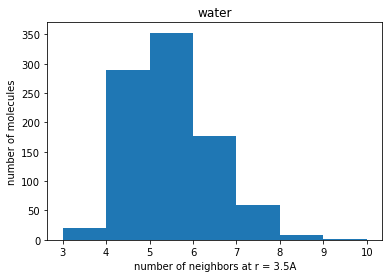

In [52]:
plt.hist(sort,bins = np.linspace(3,10,8))
plt.xlabel("number of neighbors at r = 3.5A")
plt.ylabel("number of molecules")
plt.title("water")

In [44]:
uc.trajectory[50]
p = uc.select_atoms('name OW')
o = p.atoms.positions
bins, rdf, op, sortc = lechner(o, o, cbox, 1, 50, 3.5, 3)

Text(0, 0.5, 'number of molecules')

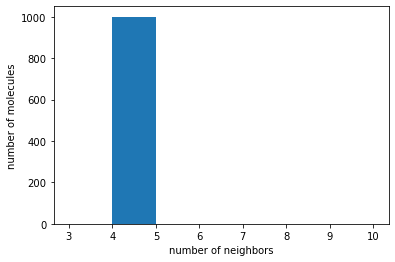

In [57]:
plt.hist(sortc,bins = np.linspace(3,10,8))
plt.xlabel("number of neighbors")
plt.ylabel("number of molecules")
# plt.title("cubic ice")

In [47]:
uh.trajectory[50]
p = uh.select_atoms('name OW')
o = p.atoms.positions
bins, rdf, op, sorth = lechner(o, o, hbox, 1, 50, 3.5, 3)

Text(0.5, 1.0, 'hexagonal ice & cubic ice')

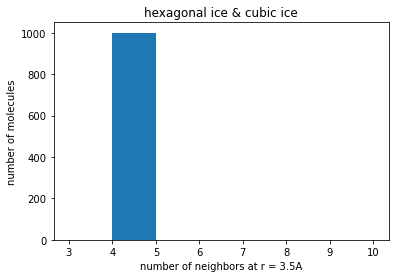

In [56]:
plt.hist(sortc,bins = np.linspace(3,10,8))
plt.xlabel("number of neighbors at r = 3.5A")
plt.ylabel("number of molecules")
plt.title("hexagonal ice & cubic ice")

In [22]:
a = np.zeros((5,))
print(a)

[0. 0. 0. 0. 0.]


In [67]:
def op_average(u, array, fs_atom_name, sn_atom_name , box, x_max, n_bins, cutoff, l):

    '''
    Input:
      array(numpy.ndarray) : (n_time_frames)  ex) [0,100,200,300...,1000]
      
    output:
      bins(numpy.ndarray) : (n_bins,) array of bins
      gr_average(numpy.ndarray) : (n_bins, ) radial distribution function
      nr_average(numpy.ndarray) : (n_bins, ) number of cumulative molecules
    
    '''
    
    u.trajectory[0]
    p = u.select_atoms(fs_atom_name)
    o = p.atoms.positions
    N = o.shape[0] # number of molecules

    
    rdf__ = np.zeros(n_bins)
    opp = np.zeros((N,))
    n_bins = n_bins
    
    for i in array:
        u.trajectory[np.int(i)]
        p = u.select_atoms(fs_atom_name)
        pp = u.select_atoms(sn_atom_name)
        bins, rdf_, op = lechner(p.atoms.positions, pp.atoms.positions, box, x_max, n_bins, cutoff, l)
        rdf__ += rdf_
        opp += op

    
    return bins, rdf__/len(array), op#opp/len(array)

In [68]:
wbins, wrdf_, wop = op_average(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 3.5, 3)

In [69]:
hbins, hrdf_, hop = op_average(uh, np.linspace(0,1000,20),"name OW", "name OW", hbox, 1, 50, 3.5, 3)

In [70]:
cbins, crdf_, cop = op_average(uc, np.linspace(0,1000,20),"name OW", "name OW", cbox, 1, 50, 3.5, 3)

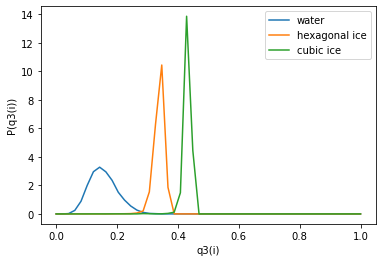

In [36]:
plt.plot(wbins, wrdf_/50, label='water')
plt.plot(hbins, hrdf_/50, label='hexagonal ice')
plt.plot(cbins,crdf_/50, label='cubic ice')
plt.xlabel("q3(i)")
plt.ylabel("P(q3(i))")

plt.legend()

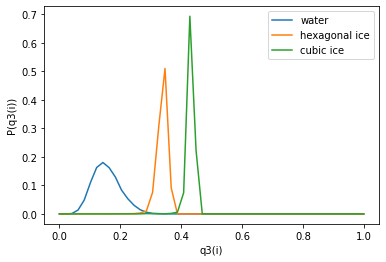

In [71]:
plt.plot(wbins, wrdf_/909, label='water')
plt.plot(hbins, hrdf_/1024, label='hexagonal ice')
plt.plot(cbins,crdf_/1000, label='cubic ice')
plt.xlabel("q3(i)")
plt.ylabel("P(q3(i))")

plt.legend()

In [72]:
wwbins, wwrdf_, wwop = op_average(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 3.5, 6)
hhbins, hhrdf_, hhop = op_average(uh, np.linspace(0,1000,20),"name OW", "name OW", hbox, 1, 50, 3.5, 6)
ccbins, ccrdf_, ccop = op_average(uc, np.linspace(0,1000,20),"name OW", "name OW", cbox, 1, 50, 3.5, 6)

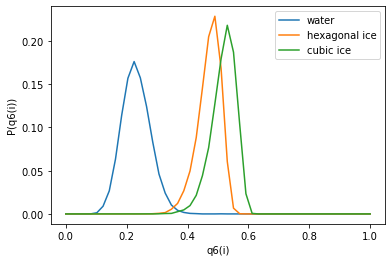

In [73]:
plt.plot(wwbins, wwrdf_/909, label='water')
plt.plot(hhbins, hhrdf_/1024, label='hexagonal ice')
plt.plot(ccbins,ccrdf_/1000, label='cubic ice')
plt.xlabel("q6(i)")
plt.ylabel("P(q6(i))")

plt.legend()

In [24]:
uc.trajectory[50]
p = uc.select_atoms('name OW')
o = p.atoms.positions

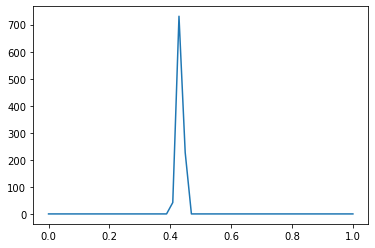

In [25]:
bins, rdf, op = lechner(o, o, cbox, 1, 50, 3.5, 3)
plt.plot(bins,rdf)